In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# **Veri Setinin Yüklenmesi**
Veri seti, belirtilen dizinden yüklenir ve etiketler ile dosya yolları toplanır.

In [2]:
data_dir='/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset' 


In [3]:
# Etiket ve dosya yollarını toplamak için listeler
label = []
path = []

# Klasördeki dosya yollarını ve etiketleri topluyoruz
for dir_name, _, filenames in os.walk(data_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':  # Sadece .png dosyalarını al
            if dir_name.split()[-1] != 'GT':  # 'GT' klasörünü hariç tut
                label.append(os.path.split(dir_name)[-1])  # Klasör adını etiket olarak al
                path.append(os.path.join(dir_name, filename))  # Tam dosya yolunu ekle

# Toplanan dosya yollarını ve etiketleri bir DataFrame'e dönüştür
data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label

In [4]:
data.head(10)

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
5,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
6,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
7,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
8,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
9,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel


In [5]:
data.isnull().sum()

path     0
label    0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


# **Balık Türlerinin Dağılımı**
Balık türlerinin dağılımını gösteren çubuk grafiği:

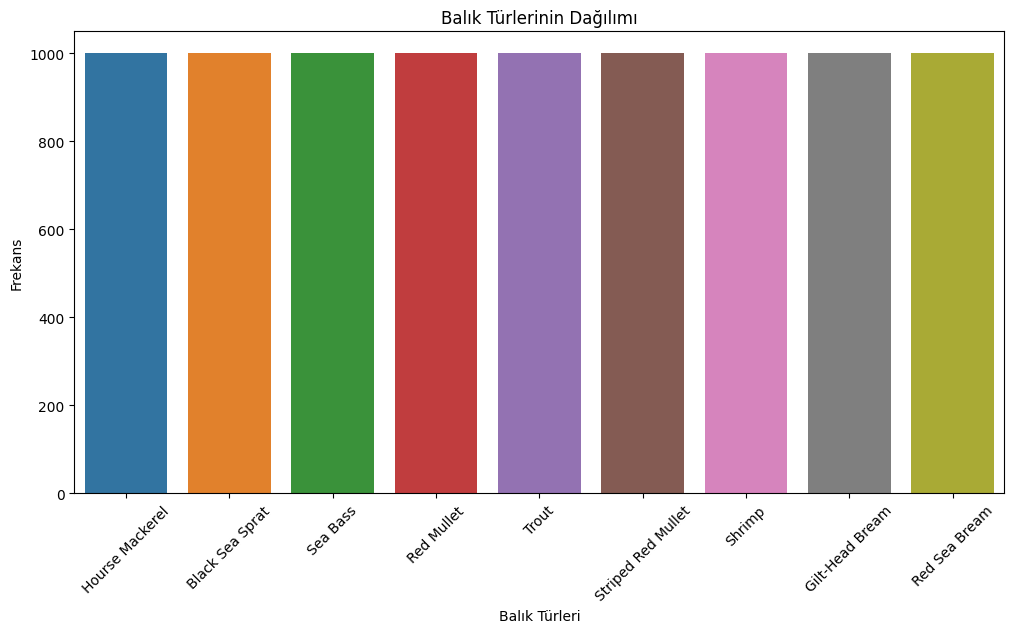

In [7]:

plt.figure(figsize=(12, 6))
sns.countplot(x='label', data=data)  
plt.title('Balık Türlerinin Dağılımı')
plt.xlabel('Balık Türleri')
plt.ylabel('Frekans')
plt.xticks(rotation=45)
plt.show()

# **Veri Ön İşleme**
Resimleri yükleyip ön işlemek için bir fonksiyon tanımlanır:

In [8]:
def load_and_preprocess_data(data, img_height, img_width):
    images = []
    labels = []
    
    for img_path, label in zip(data['path'], data['label']):
        # Resmi yükle ve boyutlandır
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0  # Normalleştirme
        images.append(img_array)
        labels.append(label)

    # NumPy dizisine dönüştür
    X = np.array(images)
   # Etiketleri sayısal forma çevir
    le = LabelEncoder()
    y = le.fit_transform(labels)
    y = to_categorical(y)

    return X, y

In [9]:
# Parametreleri tanımla
img_height = 128
img_width = 128

## **Veri Ön İşleme**
- Görüntü dosyaları `.png` formatında alındı ve etiketleri balık türlerine göre toplandı.
- Görüntüler `img_to_array` fonksiyonu ile numpy array formatına dönüştürüldü.
- Veriler eğitim ve test setlerine bölündü.
- Görüntü verileri normalize edilerek [0, 1] aralığına çekildi.

In [10]:
from sklearn.preprocessing import LabelEncoder
# Veri yükle ve ön işle
X, y = load_and_preprocess_data(data, img_height, img_width)

In [11]:
# Yüklenen ve işlenen verinin boyutunu kontrol et
print("Görüntülerin boyutu:", X.shape)
print("Etiketlerin boyutu:", y.shape)

Görüntülerin boyutu: (9000, 128, 128, 3)
Etiketlerin boyutu: (9000, 9)


In [12]:
# Veriyi eğitim ve test setine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Eğitim seti boyutu:", X_train.shape)
print("Test seti boyutu:", X_test.shape)

Eğitim seti boyutu: (7200, 128, 128, 3)
Test seti boyutu: (1800, 128, 128, 3)


## **Modelin Yapısı**
Modelde yapay sinir ağı kullanılmıştır. Modelin temel katmanları aşağıdaki gibidir:
- **Girdi Katmanı**: Görüntülerin array formatında modele verilmesi sağlanır.
- **Ara Katmanlar**: Modelde dört tam bağlı katman kullanılmıştır (512, 256, 128, 64 nöron). Her katmanda:
    - Leaky ReLU aktivasyonu tercih edilmiştir.
    - Aşırı öğrenmeyi önlemek için `BatchNormalization` ve `Dropout` (0.5 oranında) eklenmiştir.
- **Çıkış Katmanı**: Softmax aktivasyonu ile balık türlerinin sınıflandırılması gerçekleştirilir.


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU

# ANN modelini oluşturalım
model = Sequential()

# Flatten katmanı (128x128 görüntüleri düzleştiriyoruz)
model.add(Flatten(input_shape=(img_height, img_width, 3)))

# İlk tam bağlı katman (512 nöron, Leaky ReLU aktivasyonu)
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU aktivasyonu
model.add(BatchNormalization())  # Batch Normalization ekledik
model.add(Dropout(0.5))  # Dropout ile aşırı öğrenmeyi engelliyoruz

# İkinci tam bağlı katman (256 nöron, Leaky ReLU aktivasyonu)
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU aktivasyonu
model.add(BatchNormalization())  # Batch Normalization ekledik
model.add(Dropout(0.5))  # Dropout katmanı ekledik

# Üçüncü tam bağlı katman (128 nöron, Leaky ReLU aktivasyonu)
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU aktivasyonu
model.add(BatchNormalization())  # Batch Normalization
model.add(Dropout(0.5))  # Dropout ekliyoruz

# Dördüncü tam bağlı katman (64 nöron, Leaky ReLU aktivasyonu)
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU aktivasyonu
model.add(BatchNormalization())  # Batch Normalization
model.add(Dropout(0.5)) 

# Beşinci tam bağlı katman (64 nöron, Leaky ReLU aktivasyonu)
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU aktivasyonu
model.add(BatchNormalization())  # Batch Normalization
model.add(Dropout(0.5))

# Altıncı tam bağlı katman (32 nöron, Leaky ReLU aktivasyonu)
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU aktivasyonu
model.add(BatchNormalization())  # Batch Normalization
model.add(Dropout(0.5)) 

# Çıkış katmanı (Softmax aktivasyonu, balık türlerine göre 9 sınıf)
model.add(Dense(9, activation='softmax'))

# Modeli derleme 
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Modelin özetini görelim
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 25,352,073 (96.71 MB)

 Trainable params: 25,349,897 (96.70 MB)

 Non-trainable params: 2,176 (8.50 KB)

## ** Model Eğitimi**
- **Optimizasyon**: Adam optimizasyon algoritması kullanılmıştır.
- **Kayıp Fonksiyonu**: Çok sınıflı sınıflandırma için categorical_crossentropy kullanılmıştır.
- **Epoch**: Model 50 epoch boyunca eğitilmiştir.

In [27]:
# Modeli eğitelim
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))


Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.1172 - loss: 3.3606 - val_accuracy: 0.1789 - val_loss: 2.1606
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1353 - loss: 3.1017 - val_accuracy: 0.2011 - val_loss: 2.0409
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1544 - loss: 2.8945 - val_accuracy: 0.2244 - val_loss: 1.9754
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1528 - loss: 2.8341 - val_accuracy: 0.2828 - val_loss: 1.9077
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1695 - loss: 2.6457 - val_accuracy: 0.3100 - val_loss: 1.8702
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1754 - loss: 2.6132 - val_accuracy: 0.3306 - val_loss: 1.8242
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1867 - loss: 2.5127 - val_accuracy: 0.3567 - val_loss: 1.7920
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2046 - loss: 2.4323 - val_accuracy: 

## **Performans Değerlendirme**
Modelin eğitim ve doğrulama doğruluğu ile kayıpları aşağıdaki grafikler aracılığıyla görselleştirilmiştir:
- **Doğruluk Grafiği**: Eğitim ve doğrulama doğruluğunu gösterir.
- **Kayıp Grafiği**: Eğitim ve doğrulama kayıplarını gösterir.

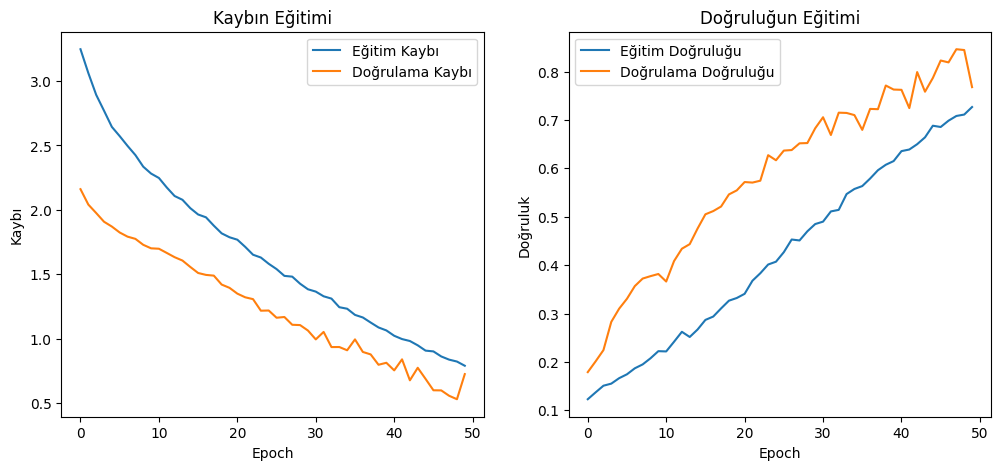

In [29]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Kayıplar
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title('Kaybın Eğitimi')
    plt.xlabel('Epoch')
    plt.ylabel('Kaybı')
    plt.legend()

    # Doğruluk
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
    plt.title('Doğruluğun Eğitimi')
    plt.xlabel('Epoch')
    plt.ylabel('Doğruluk')
    plt.legend()

    plt.show()

# Grafikleri çiz
plot_training_history(history)

## **Sonuç**
Bu yapay sinir ağı modeli, balık türlerini başarılı bir şekilde sınıflandırmak için geliştirilmiştir. Modelin optimizasyonu ve performans iyileştirme aşamalarında veri augmentasyonu ve erken durdurma yöntemleri eklenebilir.